In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.utils import *
from sklearn.preprocessing import *
import keras.backend as K

Using TensorFlow backend.
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
China_concat = pd.read_csv('../data/Concat/China_concat.csv', header=0)
Asia_concat = pd.read_csv('../data/Concat/Asia_concat.csv', header=0)
America_concat = pd.read_csv('../data/Concat/America_concat.csv', header=0)
Africa_concat = pd.read_csv('../data/Concat/Africa_concat.csv', header=0)
Europe_concat = pd.read_csv('../data/Concat/Europe_concat.csv', header=0)
Oceania_concat = pd.read_csv('../data/Concat/Oceania_concat.csv', header=0)

In [3]:
Test = pd.read_csv('../data/Test/Africa_test_data.csv')
Test['Date'] = [20200429, 20200430, 20200501,20200502,20200503,20200504,20200505]
Test.set_index('Date',inplace=True)

In [4]:
df = pd.DataFrame()

Africa_concat.set_index('Date',inplace=True)
label = Africa_concat[Africa_concat.columns[-1]]
#test_df = label[-7:]
Africa_concat = Africa_concat.loc[20200101:20200428]


df['Confirm'] = (Africa_concat['Daily_confirmed'] + Africa_concat['Daily_deaths']) / Africa_concat['Total_confirmed']
df['Flight'] = Africa_concat['Passenger_arrivals'] / Africa_concat['Flight_arrivals']
df['Ship'] = ( Africa_concat['Ship_crew(korea)'] + Africa_concat['Ship_crew(foreign)'] + Africa_concat['Ship_passenger'] ) / Africa_concat['Ship_count']
df['News'] = Africa_concat['News_Negative'] / Africa_concat['News_Sum']
#df['Date'] = Asia_concat['Date'].astype(int)
    
df.fillna(0, inplace = True)
#df.set_index('Date',inplace=True)



In [5]:
sc = MinMaxScaler()

df['Confirm'] = sc.fit_transform(pd.DataFrame(df['Confirm']))
df['Flight'] = sc.fit_transform(pd.DataFrame(df['Flight']))
df['Ship'] = sc.fit_transform(pd.DataFrame(df['Ship']))
df['News'] = sc.fit_transform(pd.DataFrame(df['News']))

In [6]:
df = pd.concat([df,Test])

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out+1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [8]:
df_s = series_to_supervised(df, 14, 0)

In [9]:
#df_s = df

In [10]:
X_train = np.array(df_s.loc[:20200428])
X_test = np.array(df_s.loc[20200429:])

y_train = np.array(label.loc[20200115:20200428])
y_test = np.array(label.loc[20200429:20200505])

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((105, 60, 1), (7, 60, 1), (105,), (7,))

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.models import load_model


K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
xInput = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))
xLstm_1 = LSTM(20, return_sequences = True, activation='tanh', recurrent_activation='sigmoid')(xInput)
#xLstm_2 = LSTM(20, return_sequences = True, activation='tanh', recurrent_activation='sigmoid')(xLstm_1)
#xLstm_3 = LSTM(50, return_sequences = True, activation='tanh', recurrent_activation='sigmoid')(xLstm_2)
xLstm_4 = Bidirectional(LSTM(20))(xLstm_1)
xOutput = Dense(1)(xLstm_4)


model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer='adam', metrics = [ 'mae' ])


 # 학습
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=2)

model.fit(X_train, y_train, epochs=2000, batch_size=1, verbose=2, shuffle=False)



 # 예측
y_hat = model.predict(X_test, batch_size=1)


Epoch 1/2000
 - 3s - loss: 0.0480 - mae: 0.0600
Epoch 2/2000
 - 2s - loss: 0.0478 - mae: 0.0568
Epoch 3/2000
 - 2s - loss: 0.0477 - mae: 0.0559
Epoch 4/2000
 - 2s - loss: 0.0475 - mae: 0.0551
Epoch 5/2000
 - 2s - loss: 0.0473 - mae: 0.0548
Epoch 6/2000
 - 2s - loss: 0.0472 - mae: 0.0549
Epoch 7/2000
 - 2s - loss: 0.0469 - mae: 0.0548
Epoch 8/2000
 - 3s - loss: 0.0466 - mae: 0.0549
Epoch 9/2000
 - 3s - loss: 0.0463 - mae: 0.0548
Epoch 10/2000
 - 2s - loss: 0.0457 - mae: 0.0557
Epoch 11/2000
 - 2s - loss: 0.0452 - mae: 0.0574
Epoch 12/2000
 - 2s - loss: 0.0448 - mae: 0.0609
Epoch 13/2000
 - 3s - loss: 0.0445 - mae: 0.0611
Epoch 14/2000
 - 2s - loss: 0.0436 - mae: 0.0644
Epoch 15/2000
 - 2s - loss: 0.0431 - mae: 0.0653
Epoch 16/2000
 - 2s - loss: 0.0423 - mae: 0.0700
Epoch 17/2000
 - 2s - loss: 0.0412 - mae: 0.0727
Epoch 18/2000
 - 2s - loss: 0.0402 - mae: 0.0757
Epoch 19/2000
 - 2s - loss: 0.0389 - mae: 0.0769
Epoch 20/2000
 - 2s - loss: 0.0379 - mae: 0.0830
Epoch 21/2000
 - 2s - loss: 

 - 2s - loss: 0.0011 - mae: 0.0153
Epoch 161/2000
 - 2s - loss: 7.1778e-04 - mae: 0.0128
Epoch 162/2000
 - 2s - loss: 3.5131e-04 - mae: 0.0121
Epoch 163/2000
 - 2s - loss: 2.7912e-04 - mae: 0.0106
Epoch 164/2000
 - 2s - loss: 4.0918e-04 - mae: 0.0124
Epoch 165/2000
 - 2s - loss: 8.4576e-04 - mae: 0.0139
Epoch 166/2000
 - 2s - loss: 0.0019 - mae: 0.0201
Epoch 167/2000
 - 2s - loss: 0.0089 - mae: 0.0405
Epoch 168/2000
 - 2s - loss: 0.0247 - mae: 0.0681
Epoch 169/2000
 - 2s - loss: 0.0288 - mae: 0.0602
Epoch 170/2000
 - 2s - loss: 0.0056 - mae: 0.0394
Epoch 171/2000
 - 2s - loss: 0.0020 - mae: 0.0260
Epoch 172/2000
 - 2s - loss: 9.8290e-04 - mae: 0.0215
Epoch 173/2000
 - 2s - loss: 6.9964e-04 - mae: 0.0180
Epoch 174/2000
 - 2s - loss: 4.6846e-04 - mae: 0.0162
Epoch 175/2000
 - 2s - loss: 4.1461e-04 - mae: 0.0150
Epoch 176/2000
 - 2s - loss: 3.2929e-04 - mae: 0.0138
Epoch 177/2000
 - 2s - loss: 3.2473e-04 - mae: 0.0134
Epoch 178/2000
 - 2s - loss: 2.8269e-04 - mae: 0.0126
Epoch 179/2000
 -

Epoch 316/2000
 - 2s - loss: 9.5482e-05 - mae: 0.0076
Epoch 317/2000
 - 2s - loss: 9.6919e-05 - mae: 0.0076
Epoch 318/2000
 - 2s - loss: 9.7990e-05 - mae: 0.0075
Epoch 319/2000
 - 3s - loss: 1.3516e-04 - mae: 0.0082
Epoch 320/2000
 - 2s - loss: 1.9261e-04 - mae: 0.0086
Epoch 321/2000
 - 2s - loss: 3.3208e-04 - mae: 0.0101
Epoch 322/2000
 - 3s - loss: 2.8961e-04 - mae: 0.0100
Epoch 323/2000
 - 2s - loss: 5.1897e-04 - mae: 0.0118
Epoch 324/2000
 - 2s - loss: 7.7007e-04 - mae: 0.0142
Epoch 325/2000
 - 2s - loss: 7.1531e-04 - mae: 0.0138
Epoch 326/2000
 - 2s - loss: 4.7372e-04 - mae: 0.0127
Epoch 327/2000
 - 2s - loss: 2.1374e-04 - mae: 0.0095
Epoch 328/2000
 - 2s - loss: 1.3632e-04 - mae: 0.0079
Epoch 329/2000
 - 2s - loss: 9.9148e-05 - mae: 0.0070
Epoch 330/2000
 - 2s - loss: 8.4273e-05 - mae: 0.0068
Epoch 331/2000
 - 2s - loss: 7.1957e-05 - mae: 0.0063
Epoch 332/2000
 - 3s - loss: 7.0560e-05 - mae: 0.0062
Epoch 333/2000
 - 3s - loss: 6.5885e-05 - mae: 0.0060
Epoch 334/2000
 - 2s - loss:

Epoch 469/2000
 - 3s - loss: 9.4394e-04 - mae: 0.0083
Epoch 470/2000
 - 3s - loss: 5.6667e-04 - mae: 0.0097
Epoch 471/2000
 - 2s - loss: 3.4225e-04 - mae: 0.0092
Epoch 472/2000
 - 3s - loss: 4.9774e-04 - mae: 0.0098
Epoch 473/2000
 - 2s - loss: 0.0055 - mae: 0.0300
Epoch 474/2000
 - 3s - loss: 0.0023 - mae: 0.0232
Epoch 475/2000
 - 3s - loss: 2.1171e-04 - mae: 0.0106
Epoch 476/2000
 - 3s - loss: 1.1072e-04 - mae: 0.0076
Epoch 477/2000
 - 3s - loss: 7.1769e-05 - mae: 0.0063
Epoch 478/2000
 - 2s - loss: 4.9147e-05 - mae: 0.0053
Epoch 479/2000
 - 3s - loss: 4.1981e-05 - mae: 0.0049
Epoch 480/2000
 - 3s - loss: 3.5244e-05 - mae: 0.0046
Epoch 481/2000
 - 3s - loss: 3.2915e-05 - mae: 0.0044
Epoch 482/2000
 - 3s - loss: 2.9454e-05 - mae: 0.0042
Epoch 483/2000
 - 3s - loss: 2.9046e-05 - mae: 0.0042
Epoch 484/2000
 - 3s - loss: 2.7065e-05 - mae: 0.0040
Epoch 485/2000
 - 3s - loss: 2.9865e-05 - mae: 0.0041
Epoch 486/2000
 - 3s - loss: 3.2259e-05 - mae: 0.0041
Epoch 487/2000
 - 3s - loss: 6.1874e

Epoch 624/2000
 - 2s - loss: 4.5778e-05 - mae: 0.0053
Epoch 625/2000
 - 3s - loss: 4.1567e-05 - mae: 0.0049
Epoch 626/2000
 - 3s - loss: 3.6625e-05 - mae: 0.0048
Epoch 627/2000
 - 3s - loss: 3.5893e-05 - mae: 0.0047
Epoch 628/2000
 - 3s - loss: 3.3564e-05 - mae: 0.0046
Epoch 629/2000
 - 3s - loss: 3.5371e-05 - mae: 0.0046
Epoch 630/2000
 - 3s - loss: 3.7202e-05 - mae: 0.0046
Epoch 631/2000
 - 3s - loss: 5.2017e-05 - mae: 0.0050
Epoch 632/2000
 - 3s - loss: 8.7446e-05 - mae: 0.0055
Epoch 633/2000
 - 3s - loss: 2.1908e-04 - mae: 0.0074
Epoch 634/2000
 - 3s - loss: 4.7245e-04 - mae: 0.0102
Epoch 635/2000
 - 3s - loss: 9.9088e-04 - mae: 0.0126
Epoch 636/2000
 - 3s - loss: 9.2041e-04 - mae: 0.0164
Epoch 637/2000
 - 3s - loss: 0.0014 - mae: 0.0185
Epoch 638/2000
 - 3s - loss: 6.3723e-04 - mae: 0.0166
Epoch 639/2000
 - 3s - loss: 5.4854e-04 - mae: 0.0106
Epoch 640/2000
 - 3s - loss: 3.4533e-04 - mae: 0.0106
Epoch 641/2000
 - 3s - loss: 1.7952e-04 - mae: 0.0085
Epoch 642/2000
 - 3s - loss: 6.7

Epoch 777/2000
 - 3s - loss: 2.4660e-04 - mae: 0.0072
Epoch 778/2000
 - 3s - loss: 0.0010 - mae: 0.0130
Epoch 779/2000
 - 3s - loss: 0.0015 - mae: 0.0166
Epoch 780/2000
 - 3s - loss: 0.0011 - mae: 0.0185
Epoch 781/2000
 - 3s - loss: 2.0710e-04 - mae: 0.0097
Epoch 782/2000
 - 3s - loss: 6.4924e-05 - mae: 0.0055
Epoch 783/2000
 - 3s - loss: 5.0127e-05 - mae: 0.0049
Epoch 784/2000
 - 3s - loss: 2.6734e-05 - mae: 0.0038
Epoch 785/2000
 - 3s - loss: 2.3686e-05 - mae: 0.0038
Epoch 786/2000
 - 3s - loss: 1.6847e-05 - mae: 0.0031
Epoch 787/2000
 - 3s - loss: 1.6517e-05 - mae: 0.0032
Epoch 788/2000
 - 3s - loss: 1.3638e-05 - mae: 0.0028
Epoch 789/2000
 - 3s - loss: 1.4184e-05 - mae: 0.0030
Epoch 790/2000
 - 3s - loss: 1.2673e-05 - mae: 0.0027
Epoch 791/2000
 - 3s - loss: 1.4300e-05 - mae: 0.0030
Epoch 792/2000
 - 3s - loss: 1.4505e-05 - mae: 0.0028
Epoch 793/2000
 - 3s - loss: 1.9801e-05 - mae: 0.0032
Epoch 794/2000
 - 3s - loss: 3.1831e-05 - mae: 0.0034
Epoch 795/2000
 - 3s - loss: 8.3561e-05 

Epoch 930/2000
 - 3s - loss: 2.1659e-05 - mae: 0.0035
Epoch 931/2000
 - 3s - loss: 1.7635e-05 - mae: 0.0032
Epoch 932/2000
 - 3s - loss: 1.5296e-05 - mae: 0.0030
Epoch 933/2000
 - 3s - loss: 1.3485e-05 - mae: 0.0028
Epoch 934/2000
 - 3s - loss: 1.2012e-05 - mae: 0.0026
Epoch 935/2000
 - 3s - loss: 1.0784e-05 - mae: 0.0025
Epoch 936/2000
 - 3s - loss: 9.7434e-06 - mae: 0.0024
Epoch 937/2000
 - 3s - loss: 8.8540e-06 - mae: 0.0023
Epoch 938/2000
 - 3s - loss: 8.0895e-06 - mae: 0.0022
Epoch 939/2000
 - 3s - loss: 7.4294e-06 - mae: 0.0021
Epoch 940/2000
 - 3s - loss: 6.8578e-06 - mae: 0.0020
Epoch 941/2000
 - 3s - loss: 6.3613e-06 - mae: 0.0019
Epoch 942/2000
 - 3s - loss: 5.9287e-06 - mae: 0.0019
Epoch 943/2000
 - 3s - loss: 5.5503e-06 - mae: 0.0018
Epoch 944/2000
 - 3s - loss: 5.2180e-06 - mae: 0.0017
Epoch 945/2000
 - 3s - loss: 4.9249e-06 - mae: 0.0017
Epoch 946/2000
 - 3s - loss: 4.6649e-06 - mae: 0.0016
Epoch 947/2000
 - 3s - loss: 4.4330e-06 - mae: 0.0016
Epoch 948/2000
 - 3s - loss:

Epoch 1081/2000
 - 3s - loss: 2.9764e-05 - mae: 0.0031
Epoch 1082/2000
 - 3s - loss: 3.0591e-05 - mae: 0.0031
Epoch 1083/2000
 - 3s - loss: 2.9712e-05 - mae: 0.0029
Epoch 1084/2000
 - 3s - loss: 3.9343e-05 - mae: 0.0030
Epoch 1085/2000
 - 3s - loss: 5.7821e-05 - mae: 0.0033
Epoch 1086/2000
 - 3s - loss: 9.1425e-05 - mae: 0.0037
Epoch 1087/2000
 - 3s - loss: 1.1256e-04 - mae: 0.0041
Epoch 1088/2000
 - 3s - loss: 1.1712e-04 - mae: 0.0043
Epoch 1089/2000
 - 3s - loss: 9.2941e-05 - mae: 0.0045
Epoch 1090/2000
 - 3s - loss: 6.7746e-05 - mae: 0.0039
Epoch 1091/2000
 - 3s - loss: 4.5968e-05 - mae: 0.0034
Epoch 1092/2000
 - 4s - loss: 3.5016e-05 - mae: 0.0029
Epoch 1093/2000
 - 4s - loss: 2.8528e-05 - mae: 0.0027
Epoch 1094/2000
 - 3s - loss: 2.5139e-05 - mae: 0.0025
Epoch 1095/2000
 - 3s - loss: 2.4793e-05 - mae: 0.0025
Epoch 1096/2000
 - 3s - loss: 2.7497e-05 - mae: 0.0025
Epoch 1097/2000
 - 3s - loss: 3.4028e-05 - mae: 0.0029
Epoch 1098/2000
 - 3s - loss: 4.7082e-05 - mae: 0.0033
Epoch 1099

Epoch 1235/2000
 - 3s - loss: 7.0973e-05 - mae: 0.0045
Epoch 1236/2000
 - 3s - loss: 4.4052e-05 - mae: 0.0042
Epoch 1237/2000
 - 3s - loss: 2.6961e-05 - mae: 0.0034
Epoch 1238/2000
 - 3s - loss: 2.3914e-05 - mae: 0.0034
Epoch 1239/2000
 - 3s - loss: 1.9133e-05 - mae: 0.0030
Epoch 1240/2000
 - 3s - loss: 2.1058e-05 - mae: 0.0032
Epoch 1241/2000
 - 3s - loss: 1.9994e-05 - mae: 0.0030
Epoch 1242/2000
 - 3s - loss: 3.0012e-05 - mae: 0.0035
Epoch 1243/2000
 - 3s - loss: 4.6688e-05 - mae: 0.0035
Epoch 1244/2000
 - 3s - loss: 1.2067e-04 - mae: 0.0052
Epoch 1245/2000
 - 3s - loss: 2.2930e-04 - mae: 0.0059
Epoch 1246/2000
 - 3s - loss: 2.3300e-04 - mae: 0.0071
Epoch 1247/2000
 - 3s - loss: 1.5521e-04 - mae: 0.0056
Epoch 1248/2000
 - 3s - loss: 1.0727e-04 - mae: 0.0055
Epoch 1249/2000
 - 3s - loss: 6.5801e-05 - mae: 0.0043
Epoch 1250/2000
 - 3s - loss: 4.9926e-05 - mae: 0.0042
Epoch 1251/2000
 - 3s - loss: 3.5494e-05 - mae: 0.0035
Epoch 1252/2000
 - 3s - loss: 3.2770e-05 - mae: 0.0037
Epoch 1253

Epoch 1385/2000
 - 3s - loss: 4.1540e-05 - mae: 0.0048
Epoch 1386/2000
 - 3s - loss: 3.6434e-05 - mae: 0.0046
Epoch 1387/2000
 - 3s - loss: 3.0495e-05 - mae: 0.0043
Epoch 1388/2000
 - 3s - loss: 2.6280e-05 - mae: 0.0040
Epoch 1389/2000
 - 3s - loss: 2.4207e-05 - mae: 0.0039
Epoch 1390/2000
 - 3s - loss: 2.6366e-05 - mae: 0.0039
Epoch 1391/2000
 - 3s - loss: 3.2952e-05 - mae: 0.0040
Epoch 1392/2000
 - 3s - loss: 5.0686e-05 - mae: 0.0042
Epoch 1393/2000
 - 3s - loss: 7.4484e-05 - mae: 0.0047
Epoch 1394/2000
 - 3s - loss: 8.6265e-05 - mae: 0.0047
Epoch 1395/2000
 - 3s - loss: 1.2513e-04 - mae: 0.0062
Epoch 1396/2000
 - 3s - loss: 0.0105 - mae: 0.0339
Epoch 1397/2000
 - 3s - loss: 0.0467 - mae: 0.0608
Epoch 1398/2000
 - 3s - loss: 0.0437 - mae: 0.0644
Epoch 1399/2000
 - 3s - loss: 0.0336 - mae: 0.0526
Epoch 1400/2000
 - 3s - loss: 0.0285 - mae: 0.0556
Epoch 1401/2000
 - 3s - loss: 0.0206 - mae: 0.0565
Epoch 1402/2000
 - 3s - loss: 0.0123 - mae: 0.0498
Epoch 1403/2000
 - 3s - loss: 0.0032 -

 - 3s - loss: 6.9829e-05 - mae: 0.0061
Epoch 1536/2000
 - 3s - loss: 5.5216e-05 - mae: 0.0054
Epoch 1537/2000
 - 3s - loss: 4.7601e-05 - mae: 0.0050
Epoch 1538/2000
 - 3s - loss: 4.2074e-05 - mae: 0.0047
Epoch 1539/2000
 - 3s - loss: 3.7836e-05 - mae: 0.0045
Epoch 1540/2000
 - 3s - loss: 3.4498e-05 - mae: 0.0043
Epoch 1541/2000
 - 3s - loss: 3.1805e-05 - mae: 0.0042
Epoch 1542/2000
 - 3s - loss: 2.9595e-05 - mae: 0.0041
Epoch 1543/2000
 - 3s - loss: 2.7755e-05 - mae: 0.0040
Epoch 1544/2000
 - 3s - loss: 2.6203e-05 - mae: 0.0039
Epoch 1545/2000
 - 3s - loss: 2.4875e-05 - mae: 0.0038
Epoch 1546/2000
 - 3s - loss: 2.3722e-05 - mae: 0.0037
Epoch 1547/2000
 - 3s - loss: 2.2706e-05 - mae: 0.0037
Epoch 1548/2000
 - 3s - loss: 2.1795e-05 - mae: 0.0036
Epoch 1549/2000
 - 3s - loss: 2.0966e-05 - mae: 0.0035
Epoch 1550/2000
 - 3s - loss: 2.0197e-05 - mae: 0.0035
Epoch 1551/2000
 - 3s - loss: 1.9474e-05 - mae: 0.0035
Epoch 1552/2000
 - 3s - loss: 1.8782e-05 - mae: 0.0034
Epoch 1553/2000
 - 3s - lo

Epoch 1685/2000
 - 3s - loss: 8.6237e-06 - mae: 0.0021
Epoch 1686/2000
 - 3s - loss: 8.2713e-06 - mae: 0.0021
Epoch 1687/2000
 - 3s - loss: 7.9476e-06 - mae: 0.0021
Epoch 1688/2000
 - 3s - loss: 7.6481e-06 - mae: 0.0020
Epoch 1689/2000
 - 3s - loss: 7.3691e-06 - mae: 0.0020
Epoch 1690/2000
 - 3s - loss: 7.1061e-06 - mae: 0.0020
Epoch 1691/2000
 - 3s - loss: 6.8569e-06 - mae: 0.0020
Epoch 1692/2000
 - 3s - loss: 6.6147e-06 - mae: 0.0019
Epoch 1693/2000
 - 3s - loss: 6.3858e-06 - mae: 0.0019
Epoch 1694/2000
 - 3s - loss: 6.1555e-06 - mae: 0.0019
Epoch 1695/2000
 - 3s - loss: 6.0161e-06 - mae: 0.0019
Epoch 1696/2000
 - 3s - loss: 6.3048e-06 - mae: 0.0019
Epoch 1697/2000
 - 3s - loss: 1.1592e-05 - mae: 0.0022
Epoch 1698/2000
 - 3s - loss: 6.4976e-05 - mae: 0.0033
Epoch 1699/2000
 - 3s - loss: 2.9149e-04 - mae: 0.0068
Epoch 1700/2000
 - 3s - loss: 1.3676e-04 - mae: 0.0052
Epoch 1701/2000
 - 3s - loss: 4.8998e-05 - mae: 0.0037
Epoch 1702/2000
 - 3s - loss: 1.4815e-05 - mae: 0.0024
Epoch 1703

Epoch 1836/2000
 - 3s - loss: 5.0144e-05 - mae: 0.0054
Epoch 1837/2000
 - 3s - loss: 4.6282e-05 - mae: 0.0047
Epoch 1838/2000
 - 3s - loss: 5.5111e-05 - mae: 0.0055
Epoch 1839/2000
 - 3s - loss: 5.0736e-05 - mae: 0.0046
Epoch 1840/2000
 - 3s - loss: 6.2721e-05 - mae: 0.0053
Epoch 1841/2000
 - 3s - loss: 5.9787e-05 - mae: 0.0044
Epoch 1842/2000
 - 3s - loss: 7.3772e-05 - mae: 0.0051
Epoch 1843/2000
 - 3s - loss: 8.9814e-05 - mae: 0.0048
Epoch 1844/2000
 - 3s - loss: 1.5085e-04 - mae: 0.0069
Epoch 1845/2000
 - 3s - loss: 2.9636e-04 - mae: 0.0095
Epoch 1846/2000
 - 3s - loss: 0.0129 - mae: 0.0381
Epoch 1847/2000
 - 3s - loss: 0.0098 - mae: 0.0272
Epoch 1848/2000
 - 3s - loss: 0.0095 - mae: 0.0260
Epoch 1849/2000
 - 3s - loss: 0.0092 - mae: 0.0270
Epoch 1850/2000
 - 3s - loss: 0.0090 - mae: 0.0276
Epoch 1851/2000
 - 4s - loss: 0.0088 - mae: 0.0282
Epoch 1852/2000
 - 3s - loss: 0.0084 - mae: 0.0289
Epoch 1853/2000
 - 3s - loss: 0.0078 - mae: 0.0299
Epoch 1854/2000
 - 3s - loss: 0.0070 - mae

 - 3s - loss: 7.8087e-05 - mae: 0.0041
Epoch 1987/2000
 - 3s - loss: 6.0878e-05 - mae: 0.0035
Epoch 1988/2000
 - 3s - loss: 4.4372e-05 - mae: 0.0032
Epoch 1989/2000
 - 3s - loss: 3.0676e-05 - mae: 0.0027
Epoch 1990/2000
 - 3s - loss: 2.3524e-05 - mae: 0.0026
Epoch 1991/2000
 - 3s - loss: 1.9147e-05 - mae: 0.0023
Epoch 1992/2000
 - 3s - loss: 1.8372e-05 - mae: 0.0024
Epoch 1993/2000
 - 3s - loss: 1.8737e-05 - mae: 0.0025
Epoch 1994/2000
 - 3s - loss: 2.2144e-05 - mae: 0.0027
Epoch 1995/2000
 - 3s - loss: 2.6776e-05 - mae: 0.0030
Epoch 1996/2000
 - 3s - loss: 3.3861e-05 - mae: 0.0032
Epoch 1997/2000
 - 3s - loss: 4.2348e-05 - mae: 0.0036
Epoch 1998/2000
 - 3s - loss: 4.9004e-05 - mae: 0.0036
Epoch 1999/2000
 - 3s - loss: 5.4879e-05 - mae: 0.0037
Epoch 2000/2000
 - 3s - loss: 5.4506e-05 - mae: 0.0034


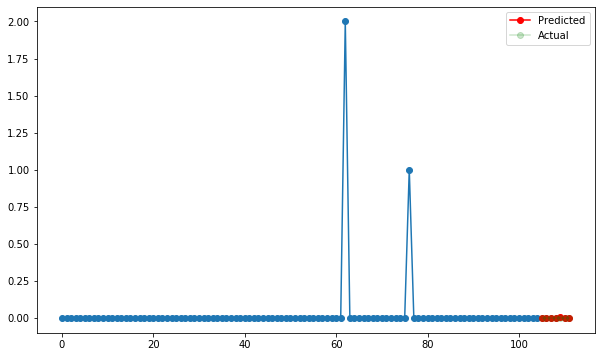

In [13]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(105,), 'o-')
plt.plot(b_axis, y_hat.reshape(7,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(7,), 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

In [14]:
y_test, y_hat

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([[-6.7260861e-04],
        [-2.7598441e-04],
        [ 3.8665533e-04],
        [ 4.8965216e-04],
        [ 5.4625124e-03],
        [-5.1096082e-05],
        [ 6.6819787e-04]], dtype=float32))

In [15]:
y_hat

array([[-6.7260861e-04],
       [-2.7598441e-04],
       [ 3.8665533e-04],
       [ 4.8965216e-04],
       [ 5.4625124e-03],
       [-5.1096082e-05],
       [ 6.6819787e-04]], dtype=float32)

In [16]:
y_test.sum(), y_hat.sum()

(0.0, 0.0060073286)

In [17]:
model.save('../model/Africa_model.h5')